In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from torch.utils.data._utils.collate import default_collate

cwd = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(cwd)))

In [2]:
from torch.utils.data import DataLoader

from src.utils.plot_timeline import plot_timeline
from src.utils.load_json import load_json
from src.utils import load_model
from src.problems import EVRP

In [3]:
# model, _ = load_model('../../outputs/evrp_4/rollout_20230614T160835') # with lots of batches and normal cost
# model, _ = load_model('../../outputs/evrp_4/rollout_20230614T160732') # with cost and lots of batches
model, _ = load_model('../../outputs/evrp_4/rollout_20230617T040439') # new
model.eval()  # Put in evaluation mode to not track gradients

  [*] Loading model from ../../outputs/evrp_4/rollout_20230617T040439/epoch-4.pt


AttentionEVRPModel(
  (init_embed_node): Linear(in_features=5, out_features=128, bias=True)
  (project_node_embeddings): Linear(in_features=128, out_features=384, bias=False)
  (project_fixed_context): Linear(in_features=128, out_features=128, bias=False)
  (encoder): GraphAttentionEncoder(
    (layers): Sequential(
      (0): MultiHeadAttentionLayer(
        (0): SkipConnection(
          (module): MultiHeadAttention()
        )
        (1): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): SkipConnection(
          (module): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
          )
        )
        (3): Normalization(
          (normalizer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MultiHeadAtten

In [4]:
def collate_fn(batch):
    data_batch, graph_batch = zip(*batch)

    return default_collate(data_batch), list(graph_batch)


In [5]:
def tensor_to_tuples(tensor):
    batch_size, features, time = tensor.shape
    edges = []
    for b in range(batch_size):
        batch_list = tuple(tensor[b, :, time - 1].tolist())
        edges.append([batch_list])

    return edges

graph_index 0


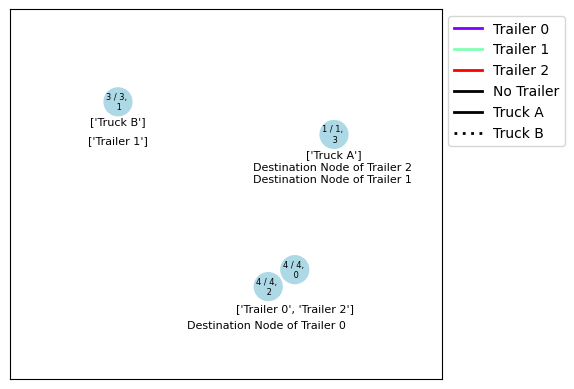

tensor([1., 3., 1., 1., 0.]) tensor([1, 1, 3])


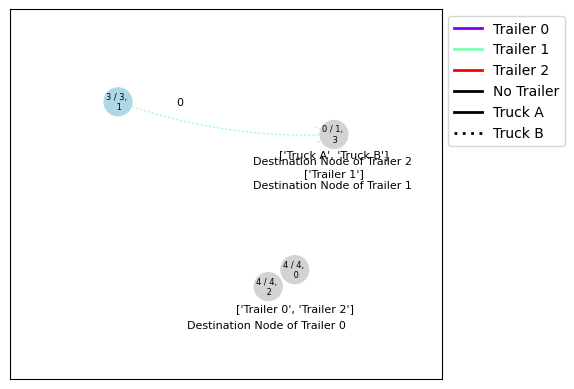

tensor([ 3.,  0.,  0., -1.,  1.]) tensor([2, 0, 0])


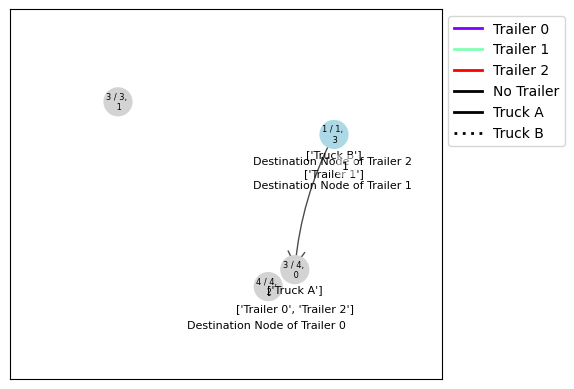

tensor([ 3.,  0.,  1., -1.,  2.]) tensor([2, 1, 0])


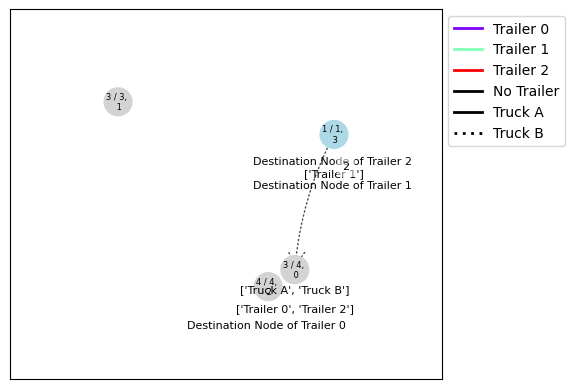

tensor([0., 3., 0., 2., 3.]) tensor([2, 0, 3])


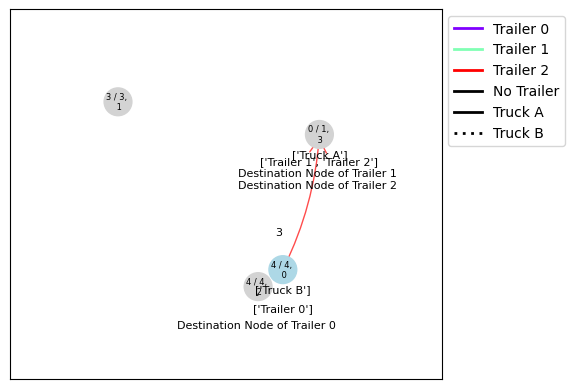

tensor([0., 2., 1., 0., 4.]) tensor([0, 1, 2])


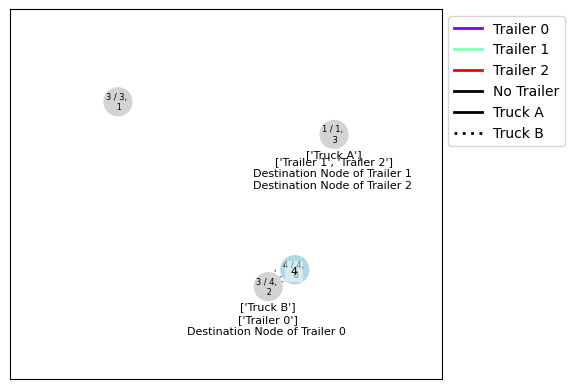

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [13]:
env = EVRP
val_dataset = env.make_dataset(
        size=4,
        num_samples=1,
        num_trucks=2,
        num_trailers=3,
        truck_names=None,
    )

# Need a dataloader to batch instances
dataloader = DataLoader(val_dataset, batch_size=1, collate_fn=collate_fn)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    length, _, edges, decision = model(batch[0].copy(), batch[1].copy(), return_pi=True)

edges=edges.permute(1,2,0)
decision=decision.permute(0, 2, 1)
for i, graph in enumerate(batch[1]):
    print("graph_index", i)
    fig, ax = plt.subplots()
    graph.draw(ax=ax, with_labels=True)
    plt.show()

    for edge, d in zip(edges[i], decision[i]):
        fig, ax = plt.subplots()
        print(edge, d)

        graph.clear()
        edge = graph.visit_edge([edge])
        graph.update_attributes(edge)
        graph.draw(ax=ax, with_labels=True)

        plt.show()

    data = edges[0].numpy().astype(int)
    plot_timeline(data)

graph_index 0


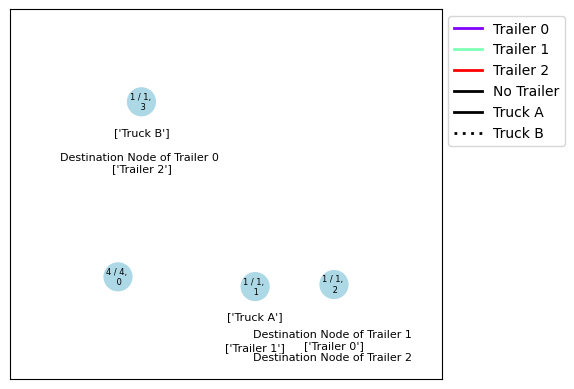

tensor([ 3.,  1.,  1., -1.,  0.]) tensor([1, 1, 1])


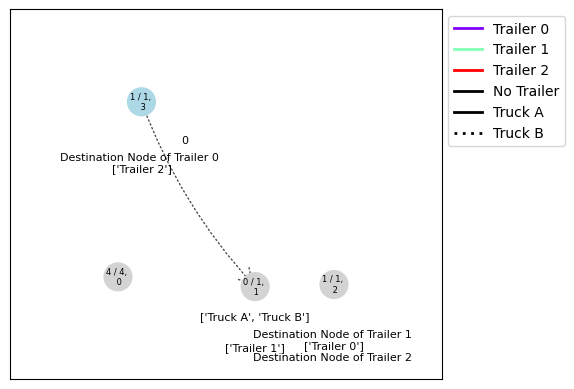

tensor([1., 2., 0., 1., 1.]) tensor([1, 0, 2])


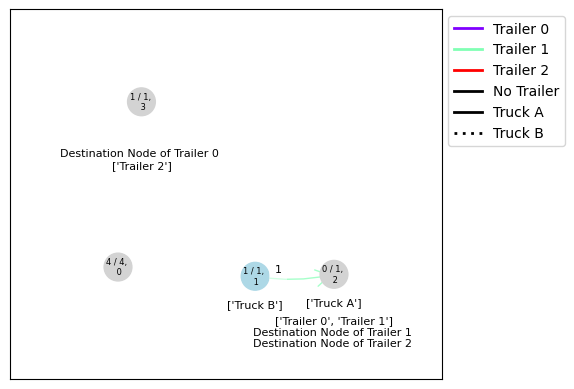

tensor([ 1.,  3.,  1., -1.,  2.]) tensor([2, 1, 3])


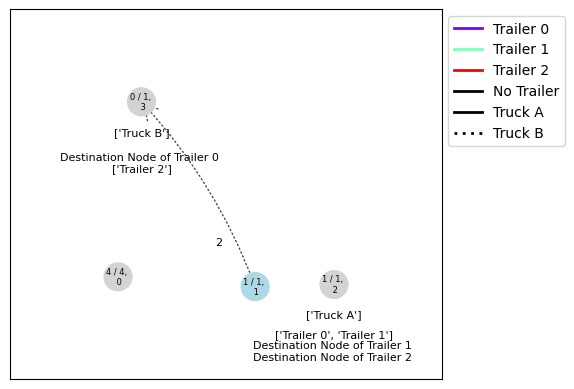

tensor([ 2.,  3.,  0., -1.,  3.]) tensor([2, 0, 3])


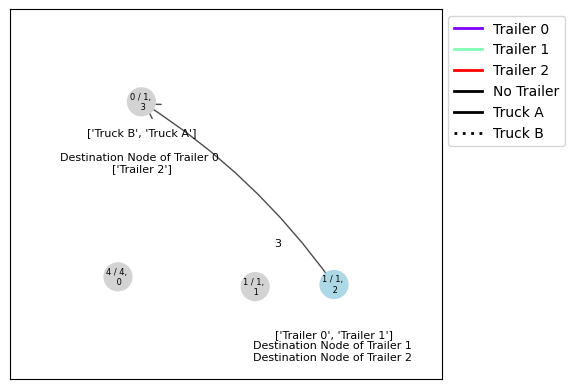

tensor([3., 2., 1., 2., 4.]) tensor([2, 1, 2])


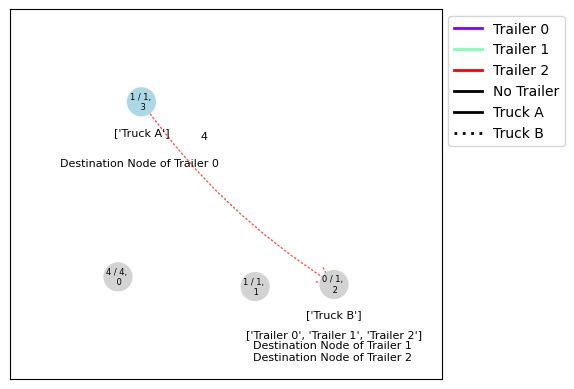

tensor([ 3.,  2.,  0., -1.,  5.]) tensor([0, 0, 2])


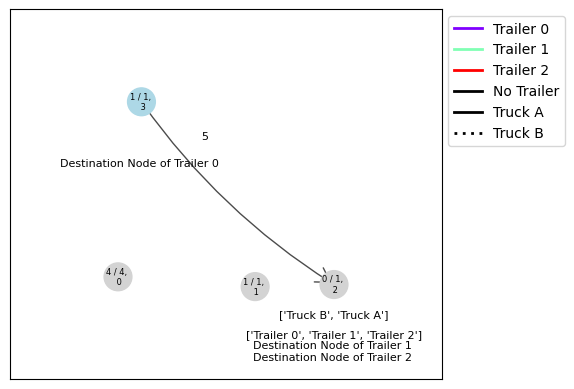

tensor([2., 1., 1., 0., 6.]) tensor([0, 1, 1])


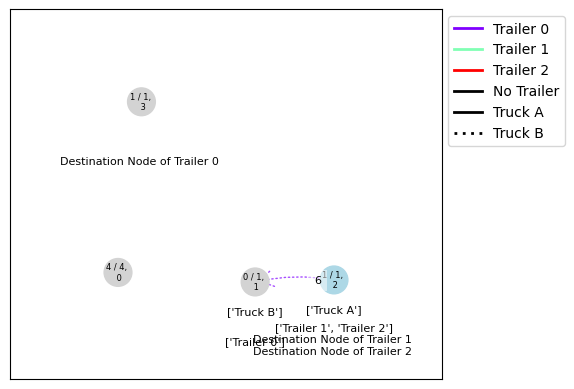

tensor([ 2.,  1.,  0., -1.,  7.]) tensor([0, 0, 1])


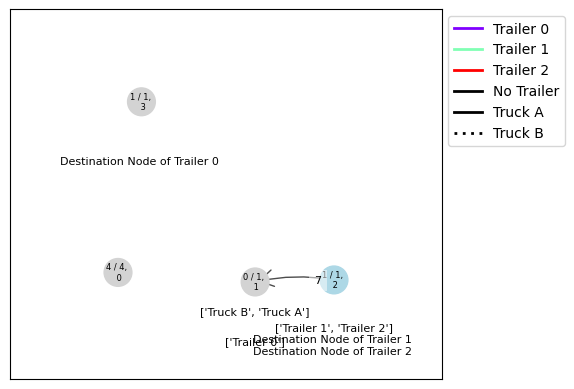

tensor([1., 3., 1., 0., 8.]) tensor([0, 1, 3])


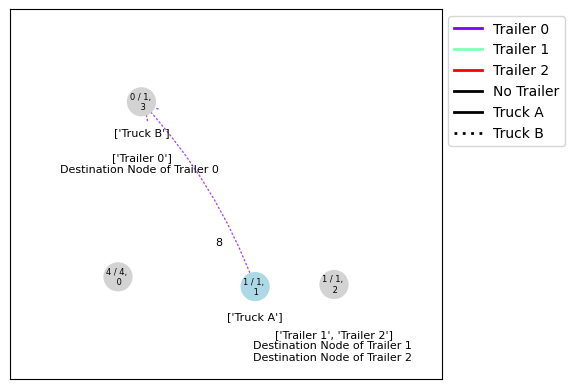

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kleiofragkedaki/Desktop/thesis/master-thesis-2023-reinforcement-learning-in-grids/src/utils/plot_timeline.py:40: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

In [9]:
env = EVRP
dataset = env.make_dataset(
        filename='../instances/example2.json'
    )

# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

# Make var works for dicts
batch = next(iter(dataloader))

# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    length, _, edges, decision = model(batch[0].copy(), batch[1].copy(), return_pi=True)

edges=edges.permute(1,2,0)
decision=decision.permute(0, 2, 1)

for i, graph in enumerate(batch[1]):
    print("graph_index", i)
    fig, ax = plt.subplots()
    graph.draw(ax=ax, with_labels=True)
    plt.show()

    for edge, d in zip(edges[i], decision[i]):
        fig, ax = plt.subplots()
        print(edge, d)

        graph.clear()
        edge = graph.visit_edge([edge])
        graph.update_attributes(edge)
        graph.draw(ax=ax, with_labels=True)

        plt.show()

    data = edges[0].numpy().astype(int)
    plot_timeline(data)